In [ ]:
# %%capture
# !gdown 1CMcTsxSzz6vzvrq_OIwOJFtowI3KHPOa
# !gdown 1JnaVPaqDA60zpT7gkq6VtIPf8nlBGi87
# !unzip Timeline20250531.zip

In [1]:
import os
len(os.listdir('Timeline20250531/cliplets/'))

13046

In [2]:
import pandas as pd
filenames = os.listdir('Timeline20250531/cliplets/')
data = pd.DataFrame({'filename': filenames})
data['letter'] = data.filename.apply(lambda x: x.split('_')[0])
data['TM'] = data.filename.apply(lambda x: int(x.split('_')[1]))
data['number'] = data.filename.apply(lambda x: x.split('_')[2].split('.')[0])
print(data.shape[0])
data.sample(5)
ground_truth_labels = data['letter'].values

13046


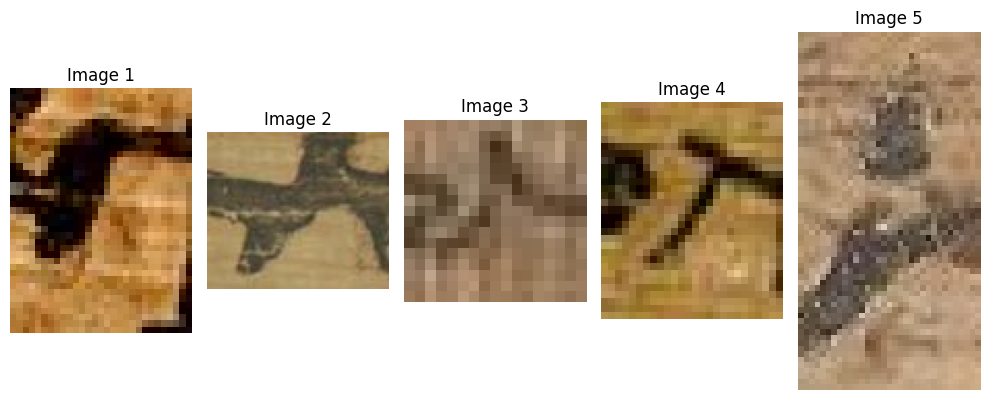

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_folder = 'Timeline20250531/cliplets/'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Display a few images
num_images_to_display = min(5, len(image_files)) # Display up to 5 images

plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    img_path = image_files[i]
    img = mpimg.imread(img_path)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

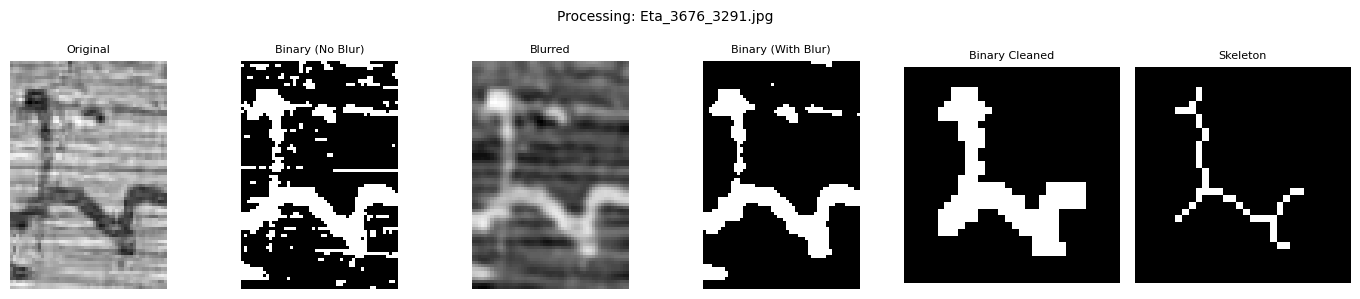

/mnt/efs/fs1/tmp/ipykernel_8721/2456001830.py:46: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)


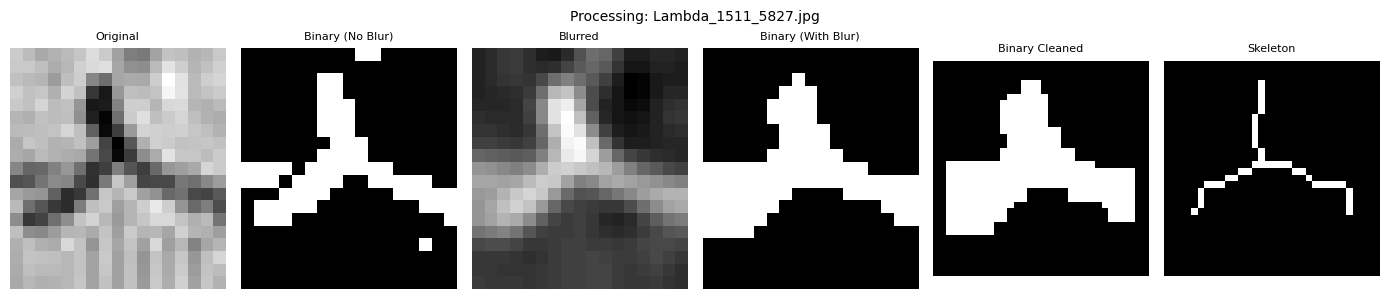

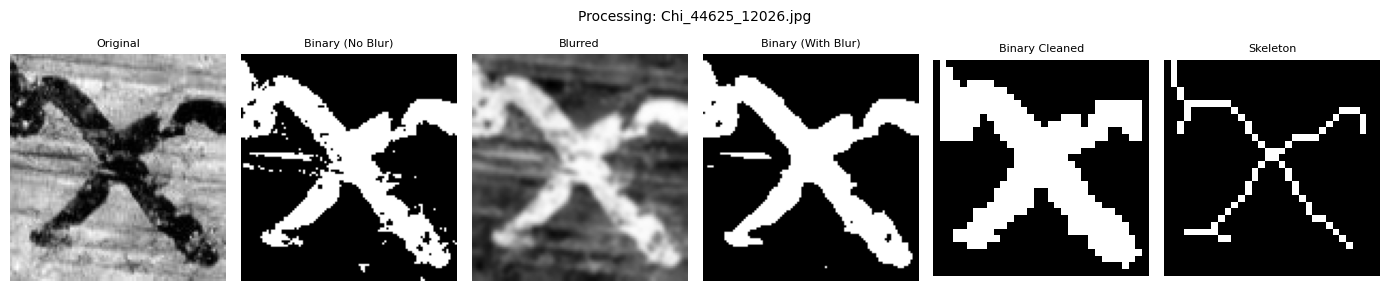

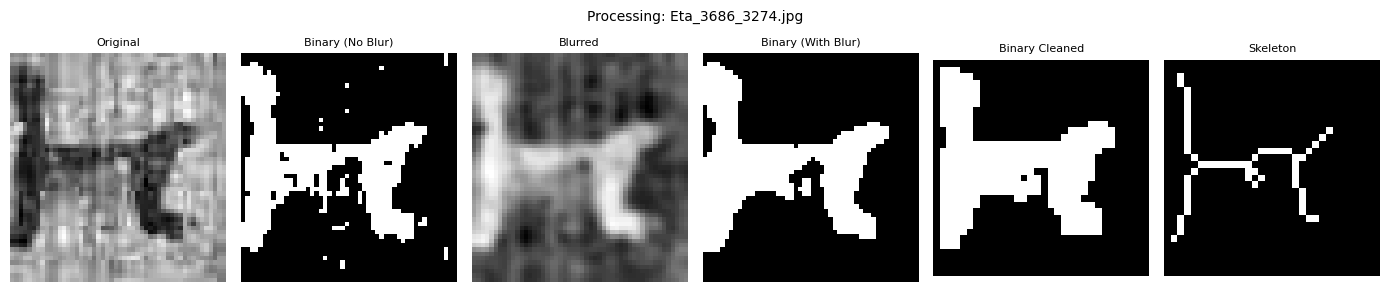

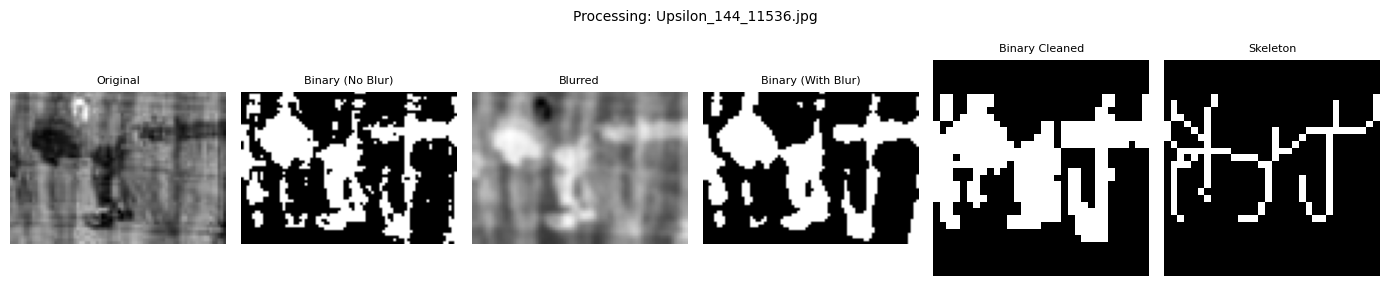

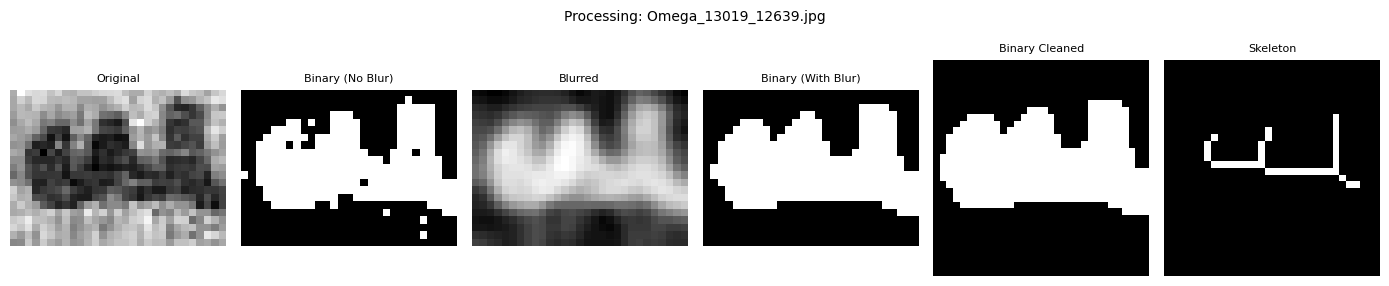

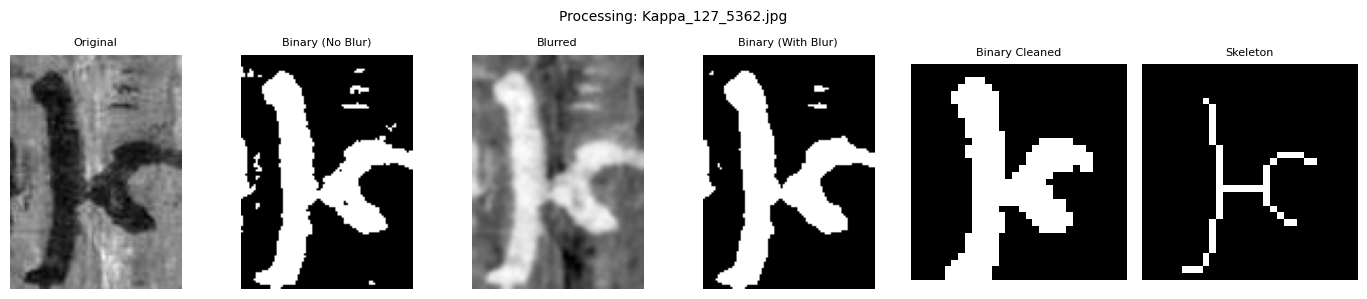

In [4]:
from skimage.morphology import skeletonize
from skimage.util import invert
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from skimage.morphology import remove_small_objects
from skimage.measure import label
import warnings
import cv2


def resize_with_aspect_ratio(image, size=(32, 32), padding_value=0):
    h, w = image.shape[:2]
    target_w, target_h = size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    result = np.full((target_h, target_w), padding_value, dtype=image.dtype)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    result[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return result

def preprocess_image_with_debug(image_path, size=(32, 32)):
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)
    # Invert image
    img_inverted = 255 - img_np

    # Without blur
    _, img_bin_noblur = cv2.threshold(img_inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # With blur
    img_blur = cv2.GaussianBlur(img_inverted, (5, 5), 0)
    _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = resize_with_aspect_ratio(img_bin, size, padding_value=0)
    
    # Remove small objects
    img_bin_bool = img_resized.astype(bool)
    img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)
    img_bin_cleaned = (img_cleaned > 0).astype(np.uint8) * 255
    
    img_sk = skeletonize(img_bin_cleaned)
    img_normalized = img_sk.astype(np.float32) / 255.0
    
    return {
        'original': img_np,
        'bin_no_blur': img_bin_noblur,
        'blurred': img_blur,
        'binary': img_bin,
        'binary_cleaned': img_bin_cleaned,
        'skeleton': img_sk,
        'final': img_normalized
    }


# Plot multiple images in a cleaner way
for img_path in image_files[100:107]:
    stages = preprocess_image_with_debug(img_path)
    if stages is None:
        continue
    fig, axs = plt.subplots(1, 6, figsize=(14, 3))
    fig.suptitle(f'Processing: {img_path.split("/")[-1]}', fontsize=10)

    axs[0].imshow(stages['original'], cmap='gray')
    axs[0].set_title('Original', fontsize=8)

    axs[1].imshow(stages['bin_no_blur'], cmap='gray')
    axs[1].set_title('Binary (No Blur)', fontsize=8)

    axs[2].imshow(stages['blurred'], cmap='gray')
    axs[2].set_title('Blurred', fontsize=8)

    axs[3].imshow(stages['binary'], cmap='gray')
    axs[3].set_title('Binary (With Blur)', fontsize=8)

    axs[4].imshow((stages['binary_cleaned'] > 0).astype(np.uint8) * 255, cmap='gray')
    axs[4].set_title('Binary Cleaned', fontsize=8)

    axs[5].imshow(stages['skeleton'], cmap='gray')
    axs[5].set_title('Skeleton', fontsize=8)

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
def preprocess_image(image_path, size=(32, 32)):
    img = Image.open(image_path).convert('L')
    img_np = np.array(img)
    # Invert image
    img_inverted = 255 - img_np

    # Blur
    img_blur = cv2.GaussianBlur(img_inverted, (5, 5), 0)
    _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_resized = resize_with_aspect_ratio(img_bin, size, padding_value=0)
    
    # Remove small objects
    img_bin_bool = img_resized.astype(bool)
    img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)
    img_bin_cleaned = (img_cleaned > 0).astype(np.uint8) * 255
    img_normalized = img_bin_cleaned.astype(np.float32) / 255.0
    return img_normalized.flatten()

image_data = []
labels = []
for i,img_path in enumerate(image_files):
    try:
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            image_data.append(processed_img)
            labels.append(ground_truth_labels[i])
    except Exception as e:
        print(f"Error processing image {image_data}: {e}")

image_data = np.array(image_data)
labels = np.array(labels)
print(f"Processed {len(image_data)} images with labels.")

/mnt/efs/fs1/tmp/ipykernel_8721/64483438.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  img_cleaned = remove_small_objects(label(img_bin_bool), min_size=40)


Processed 13046 images with labels.


In [6]:
known_data = image_data[labels != 'Unknown']
known_labels = labels[labels != 'Unknown']
print(known_data.shape, known_labels.shape)

(13014, 1024) (13014,)


Loaded 13014 images with shape (1024,)
Applying PCA with 30 components...


Clustering PCA features using Spectral Clustering...
NMI Score: 0.4200
Applying PCA with 40 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4298
Applying PCA with 50 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4321
Applying PCA with 60 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4330
Applying PCA with 70 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4308
Applying PCA with 80 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4337
Applying PCA with 90 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4325
Applying PCA with 100 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4341
Applying PCA with 120 components...
Clustering PCA features using Spectral Clustering...
NMI Score: 0.4327
Applying PCA with 150 components...
Clustering PCA features using Spectral Clus

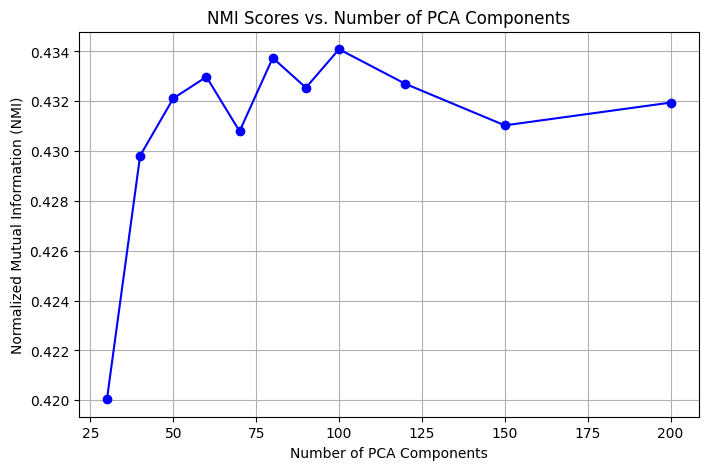

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

# 1. PCA Feature Extraction
def extract_pca_features(X, n_components):
    print(f"Applying PCA with {n_components} components...")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)

# 2. Clustering and Evaluation
def cluster_and_evaluate(X_pca, y, n_clusters=24):
    print("Clustering PCA features using Spectral Clustering...")
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(X_pca)
    nmi = normalized_mutual_info_score(y, cluster_labels)
    print(f"NMI Score: {nmi:.4f}")
    return nmi

# 3. Run PCA and Clustering for multiple component sizes
components_list = [30, 40, 50, 60, 70,80,90, 100, 120, 150, 200]
nmi_scores = []

X, y = known_data, np.array(known_labels)
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")

for n_components in components_list:
    X_pca = extract_pca_features(X, n_components)
    nmi = cluster_and_evaluate(X_pca, y)
    nmi_scores.append(nmi)

# 4. Plotting
plt.figure(figsize=(8, 5))
plt.plot(components_list, nmi_scores, marker='o', linestyle='-', color='b')
plt.title("NMI Scores vs. Number of PCA Components")
plt.xlabel("Number of PCA Components")
plt.ylabel("Normalized Mutual Information (NMI)")
plt.grid(True)
plt.show()


Loaded 13014 images with shape (1024,)
Applying PCA to reduce to 90 dimensions...


Performing Spectral Clustering on PCA features...
NMI Score: 0.4325


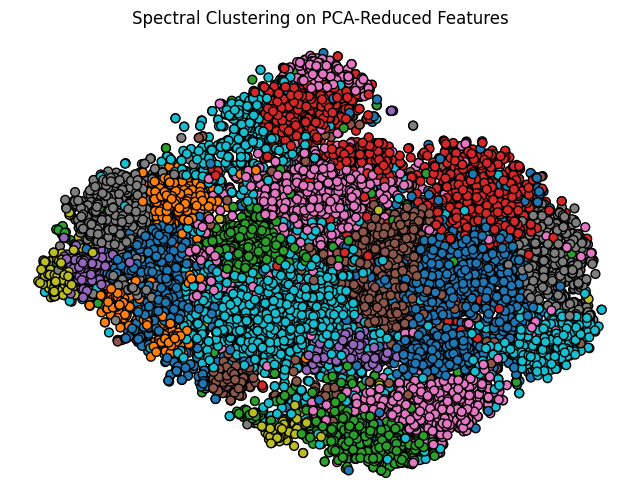

In [16]:
# 2. PCA Feature Extraction
def extract_pca_features(X, n_components=50):
    print(f"Applying PCA to reduce to {n_components} dimensions...")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)



X, y = known_data, np.array(known_labels)
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
X_pca = extract_pca_features(X, n_components=90)
print("Performing Spectral Clustering on PCA features...")
spectral = SpectralClustering(n_clusters=24, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(X_pca)

nmi = normalized_mutual_info_score(y, cluster_labels)
print(f"NMI Score: {nmi:.4f}")

# t-SNE Visualization
vis = TSNE(n_components=2, random_state=42).fit_transform(X_pca)
plt.figure(figsize=(8, 6))
plt.scatter(vis[:, 0], vis[:, 1], c=cluster_labels, cmap='tab10', s=40, edgecolor='k')
plt.title("Spectral Clustering on PCA-Reduced Features")
plt.axis('off')
plt.show()

Cluster 0 (335 images):


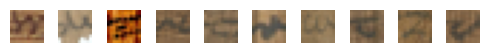

Cluster 1 (1157 images):


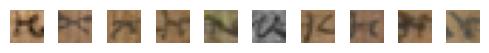

Cluster 2 (662 images):


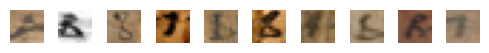

Cluster 3 (352 images):


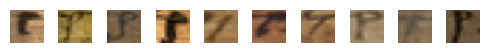

Cluster 4 (247 images):


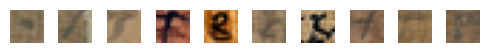

Cluster 5 (625 images):


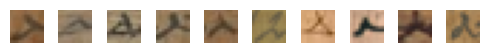

Cluster 6 (536 images):


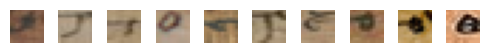

Cluster 7 (256 images):


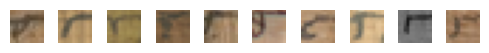

Cluster 8 (534 images):


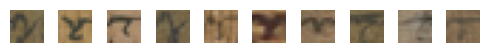

Cluster 9 (768 images):


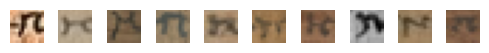

Cluster 10 (262 images):


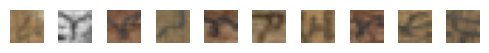

Cluster 11 (246 images):


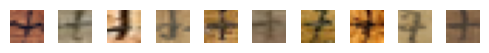

Cluster 12 (461 images):


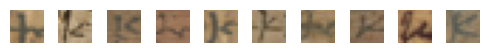

Cluster 13 (585 images):


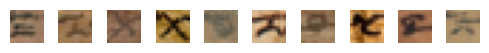

Cluster 14 (219 images):


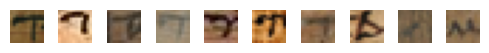

Cluster 15 (752 images):


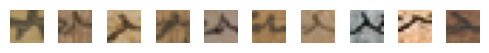

Cluster 16 (894 images):


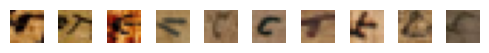

Cluster 17 (660 images):


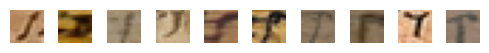

Cluster 18 (551 images):


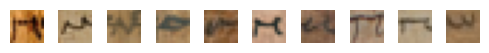

Cluster 19 (153 images):


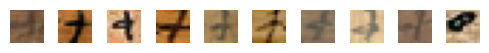

Cluster 20 (130 images):


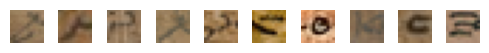

Cluster 21 (411 images):


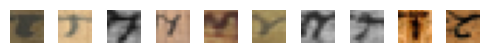

Cluster 22 (1712 images):


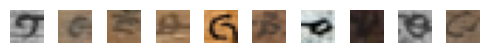

Cluster 23 (506 images):


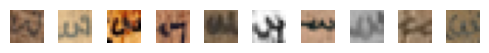

In [17]:
for cluster_id in range(24):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    num_images_in_cluster = len(cluster_indices)
    print(f"Cluster {cluster_id} ({num_images_in_cluster} images):")

    images_to_display = cluster_indices[:min(10, num_images_in_cluster)]

    if images_to_display.size > 0:
        plt.figure(figsize=(5, 10))
        for i, img_index in enumerate(images_to_display):
            img_path = image_files[img_index]
            # img = mpimg.imread(img_path)
            img = Image.open(img_path).convert('RGB').resize((12,12))
            plt.subplot(1, len(images_to_display), i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No images in this cluster to display.")

In [18]:
def create_clustered_image_grid(image_files, clusters, n_clusters, images_per_cluster_row=5):
    # Get indices of images for each cluster
    cluster_image_indices = [np.where(clusters == i)[0] for i in range(n_clusters)]

    # Determine the size of the final image
    # Assume each small image is 64x64 after preprocessing, resize for visualization
    small_img_size = (64, 64) # The preprocessed size
    display_img_size = (64, 64) # The size we want to display
    margin = 10 # Pixels between images

    # Calculate the size of each row of images for a cluster
    row_width = images_per_cluster_row * display_img_size[0] + (images_per_cluster_row - 1) * margin
    row_height = display_img_size[1]

    # Calculate the total height of the final image
    total_height = n_clusters * row_height + (n_clusters - 1) * margin
    # Calculate the maximum width needed based on the row width
    total_width = row_width # Simple grid, all rows have the same number of images

    # Create a blank canvas for the final image
    final_image = Image.new('RGB', (total_width, total_height), color='white')

    y_offset = 0
    for cluster_id in range(n_clusters):
        cluster_indices = cluster_image_indices[cluster_id]
        # Take only the first 'images_per_cluster_row' images from the cluster
        images_to_display_indices = cluster_indices[:images_per_cluster_row]

        x_offset = 0
        for img_index in images_to_display_indices:
            try:
                img_path = image_files[img_index]
                img = Image.open(img_path).convert('RGB').resize(display_img_size)
                final_image.paste(img, (x_offset, y_offset))
                x_offset += display_img_size[0] + margin
            except Exception as e:
                print(f"Could not paste image {img_path}: {e}")
                # Still add the space for the missing image
                x_offset += display_img_size[0] + margin

        y_offset += row_height + margin

    # Crop the final image to the actual content size if necessary
    actual_height = y_offset - margin if y_offset > margin else 0
    actual_width = total_width # Or adjust based on actual content

    # Recalculate actual width needed for each row
    max_actual_row_width = 0
    for cluster_id in range(n_clusters):
        images_in_row = min(len(cluster_image_indices[cluster_id]), images_per_cluster_row)
        actual_row_width = images_in_row * display_img_size[0] + (images_in_row - 1) * margin
        max_actual_row_width = max(max_actual_row_width, actual_row_width)

    actual_width = max_actual_row_width

    final_image_cropped = final_image.crop((0, 0, actual_width, actual_height))

    return final_image_cropped

# Generate the combined image grid
clustered_image_grid = create_clustered_image_grid(image_files, cluster_labels, 24, images_per_cluster_row=7) # More images per row

# Save the image
clustered_image_grid.save("clustered_images_grid.png")

print("Clustered image grid saved as clustered_images_grid.png")

Clustered image grid saved as clustered_images_grid.png


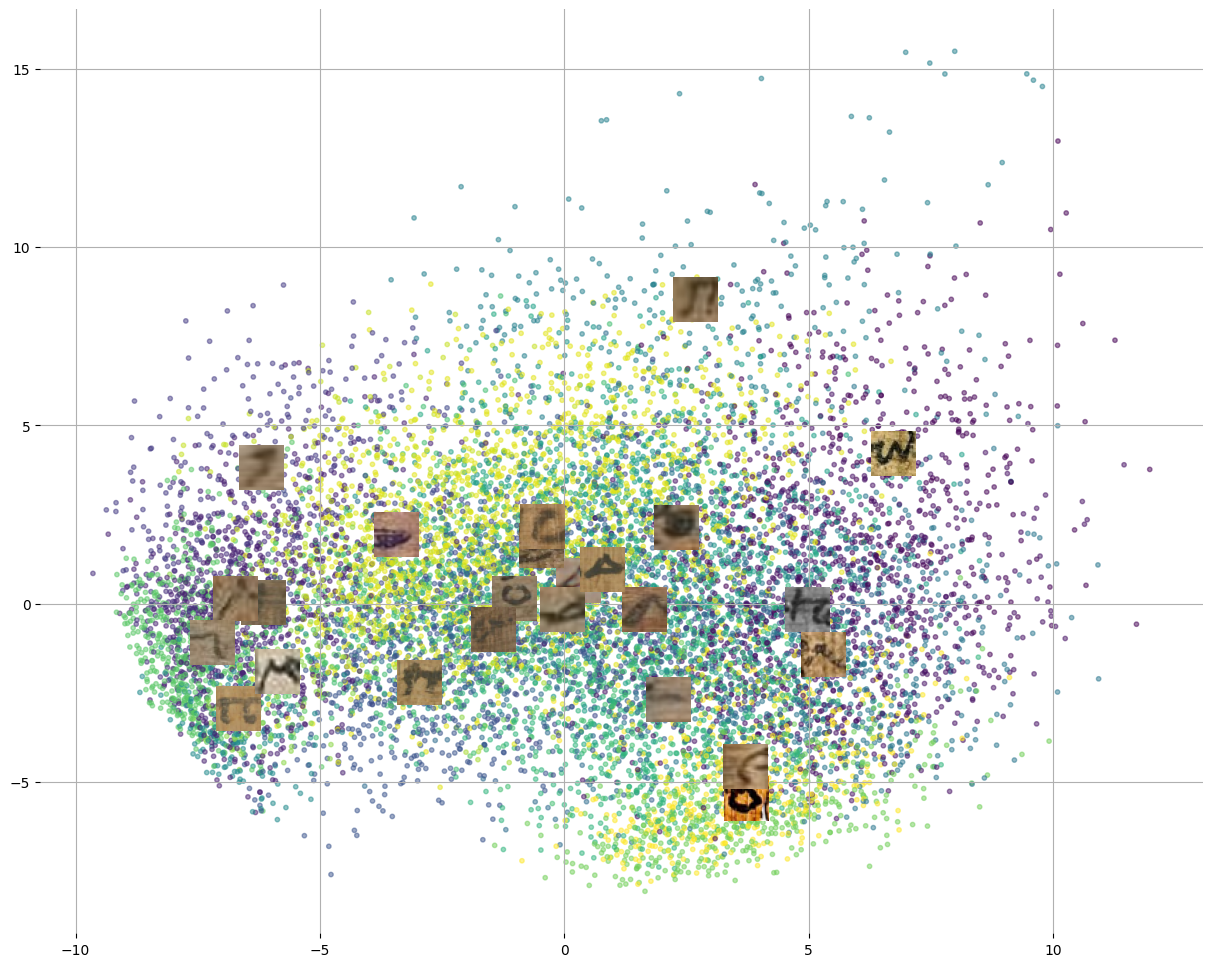

In [27]:
import seaborn as sns
plt.figure(figsize=(15, 12))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=10, alpha=0.5)
#plt.title('Image Clusters Visualization with Representative Images')
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.colorbar(scatter, label='Cluster')
plt.grid(True)

# cluster_centers = spectral.cluster_centers_
cluster_centers = np.array([
    X_pca[cluster_labels == i].mean(axis=0)
    for i in range(24)
])


for i in range(24):
    # Find indices of images in the current cluster
    indices_in_cluster = np.where(cluster_labels == i)[0]

    if len(indices_in_cluster) > 0:
        # Find the image closest to the cluster center in the 2D PCA space
        cluster_points_2d = X_pca[indices_in_cluster]
        center_2d = cluster_centers[i]

        # Calculate distances from the center to all points in the cluster
        distances = np.linalg.norm(cluster_points_2d - center_2d, axis=1)

        # Get the index of the image closest to the center within the original image_files list
        closest_image_index_in_cluster = indices_in_cluster[np.argmin(distances)]
        closest_image_path = image_files[closest_image_index_in_cluster]

        # Read and resize the closest image to a thumbnail size
        try:
            img_thumb = Image.open(closest_image_path).convert('RGB')
            img_thumb = img_thumb.resize((32, 32)) # Thumbnail size
            img_thumb_np = np.array(img_thumb)

            # Get the coordinates of the cluster center in the plot
            center_x, center_y = cluster_centers[i][:2]

            # Add the image as an annotation
            # Use AnnotationBbox to place the image at the center location
            from matplotlib.offsetbox import OffsetImage, AnnotationBbox
            imagebox = OffsetImage(img_thumb_np, zoom=1.0) # zoom can adjust size
            ab = AnnotationBbox(imagebox, (center_x, center_y), frameon=False, pad=0.1)
            plt.gca().add_artist(ab)

        except Exception as e:
            print(f"Error processing image for annotation {closest_image_path}: {e}")

sns.despine(left=True, bottom=True)
plt.savefig('image_clusters.pdf', dpi=300, format='PDF')
plt.show()

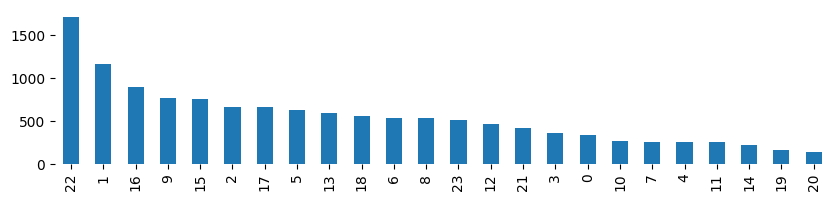

In [20]:
import seaborn as sns

pd.Series(cluster_labels).value_counts().plot.bar(figsize=(10,2));
sns.despine(left=True, bottom=True)

In [21]:
import numpy as np
from collections import Counter

num_clusters = len(set(cluster_labels))

print("Cluster Summary:")
for cluster_id in range(num_clusters):
    # Indices of samples in this cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    total_images = len(cluster_indices)

    if total_images == 0:
        print(f"Cluster {cluster_id}: Empty")
        continue

    # Get the true labels of those images
    true_labels = y[cluster_indices]

    # Count the occurrences of each label
    label_counts = Counter(true_labels)
    most_common_label, count = label_counts.most_common(1)[0]

    print(f"Cluster {cluster_id}: Total = {total_images} | Most common label = {most_common_label} ({count})")


Cluster Summary:
Cluster 0: Total = 335 | Most common label = Mu (43)
Cluster 1: Total = 1157 | Most common label = Nu (320)
Cluster 2: Total = 662 | Most common label = Beta (206)
Cluster 3: Total = 352 | Most common label = Rho (279)
Cluster 4: Total = 247 | Most common label = Rho (53)
Cluster 5: Total = 625 | Most common label = Delta (256)
Cluster 6: Total = 536 | Most common label = Omicron (266)
Cluster 7: Total = 256 | Most common label = Gamma (174)
Cluster 8: Total = 534 | Most common label = Upsilon (262)
Cluster 9: Total = 768 | Most common label = Pi (425)
Cluster 10: Total = 262 | Most common label = Epsilon (27)
Cluster 11: Total = 246 | Most common label = Phi (191)
Cluster 12: Total = 461 | Most common label = Kappa (271)
Cluster 13: Total = 585 | Most common label = Chi (201)
Cluster 14: Total = 219 | Most common label = Tau (177)
Cluster 15: Total = 752 | Most common label = Alpha (251)
Cluster 16: Total = 894 | Most common label = Sigma (348)
Cluster 17: Total = 660

In [23]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

ground_truth_labels = data['letter'].values
nmi = normalized_mutual_info_score(known_labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi}")
ari = adjusted_rand_score(known_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

Normalized Mutual Information (NMI): 0.43254672522887117
Adjusted Rand Index (ARI): 0.22798643786105516


In [24]:
from sklearn.metrics import silhouette_score, silhouette_samples
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
# Compute the average silhouette score
average_silhouette = silhouette_score(X_pca, cluster_labels)
print(f"Average Silhouette Score (Micro): {average_silhouette}")

Average Silhouette Score (Micro): 0.01654818281531334


In [25]:
cluster_silhouette_scores = []
for i in range(24):
    cluster_indices = np.where(cluster_labels == i)[0]
    if len(cluster_indices) > 1: # Silhouette score is only defined for clusters with more than one point
        cluster_silhouette_scores.append(np.mean(sample_silhouette_values[cluster_indices]).item())
macro_silhouette = np.mean(cluster_silhouette_scores) if cluster_silhouette_scores else 0
print(f"Macro Silhouette Score (Average of Cluster Averages): {macro_silhouette}")
dict(zip(range(24), cluster_silhouette_scores))

Macro Silhouette Score (Average of Cluster Averages): 0.03977244432705144


{0: 0.060909196734428406,
 1: -0.03262012451887131,
 2: -0.02971063368022442,
 3: 0.12101496011018753,
 4: 0.061355073004961014,
 5: 0.002806369448080659,
 6: 0.05570711940526962,
 7: 0.07329652458429337,
 8: 0.011520531959831715,
 9: 0.019584396854043007,
 10: 0.05058980733156204,
 11: 0.15156133472919464,
 12: 0.03767829388380051,
 13: -0.017230479046702385,
 14: 0.09362087398767471,
 15: 0.014848466962575912,
 16: -0.01667879894375801,
 17: 0.03190311789512634,
 18: 0.08506306260824203,
 19: 0.0688093900680542,
 20: 0.07406257092952728,
 21: -0.002364547224715352,
 22: -0.048336487263441086,
 23: 0.08714864403009415}

In [32]:
# prompt: compute clustering quality with all possible metrics

# Evaluate clustering quality using various metrics

# Assuming 'clusters' contains the predicted cluster labels from KMeans
# Assuming 'data' DataFrame contains the 'letter' column as ground truth labels

# Ground truth labels (e.g., based on the letter)
ground_truth_labels = data['letter'].values # Using 'letter' as ground truth

# Compute Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(known_labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi}")

# Compute Adjusted Rand Index (ARI)
ari = adjusted_rand_score(known_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# Compute Silhouette Score
# The Silhouette Score requires distance metrics. We use the PCA-transformed data.
# The silhouette score is defined for samples and is not defined for more than 2 clusters.
# The silhouette score is bounded between -1 for incorrect clustering and +1 for highly dense clustering.
# Scores around zero indicate overlapping clusters.
# Higher silhouette coefficients indicate that samples are well separated into clusters.
if len(np.unique(cluster_labels)) > 1: # Silhouette score is not defined for a single cluster
    average_silhouette = silhouette_score(X_pca, cluster_labels)
    print(f"Average Silhouette Score: {average_silhouette}")

    # Optional: Compute silhouette scores for each sample
    # sample_silhouette_values = silhouette_samples(image_data_pca, clusters)
    # print(f"Sample Silhouette Values shape: {sample_silhouette_values.shape}")
else:
    print("Silhouette Score not applicable for a single cluster.")

# Note: Since we have ground truth labels ('letter'), we can also use other metrics like:
# - Homogeneity, Completeness, V-measure (available in sklearn.metrics)
# These metrics are based on the concept of entropy and are useful when ground truth is available.
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

homogeneity = homogeneity_score(known_labels, cluster_labels)
completeness = completeness_score(known_labels, cluster_labels)
v_measure = v_measure_score(known_labels, cluster_labels)

print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")

Normalized Mutual Information (NMI): 0.43254672522887117
Adjusted Rand Index (ARI): 0.22798643786105516
Average Silhouette Score: 0.01654818281531334
Homogeneity: 0.42524182571201147
Completeness: 0.4401069817319499
V-measure: 0.43254672522887117


In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def per_class_purity(y_true, y_pred, label_names=None):
    # Encode labels to integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred = np.asarray(y_pred)

    # Build confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred)
    # Map back to class names
    classes = le.classes_ if label_names is None else label_names

    # Compute purity per true class
    purities = {}
    for i, class_name in enumerate(classes):
        total = np.sum(cm[i, :])
        correct = np.max(cm[i, :])  # cluster with max matches for this class
        purities[class_name] = correct / total if total > 0 else 0.0

    return purities
# Convert string labels to numeric and get cluster labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute per-letter purity
per_letter_purity = per_class_purity(known_labels, cluster_labels)

# Sort by purity descending
sorted_purities = sorted(per_letter_purity.items(), key=lambda x: x[1], reverse=True)

# Print nicely
print("Per-letter Purity Scores (sorted):")
for letter, purity in sorted_purities:
    print(f"Letter '{letter}': {purity:.3f}")

Per-letter Purity Scores (sorted):
Letter 'Theta': 0.831
Letter 'Omega': 0.677
Letter 'Pi': 0.668
Letter 'Beta': 0.619
Letter 'Zeta': 0.555
Letter 'Epsilon': 0.547
Letter 'Sigma': 0.504
Letter 'Nu': 0.478
Letter 'Mu': 0.471
Letter 'Chi': 0.471
Letter 'Iota': 0.463
Letter 'Xi': 0.460
Letter 'Phi': 0.458
Letter 'Delta': 0.453
Letter 'Eta': 0.431
Letter 'Omicron': 0.429
Letter 'Kappa': 0.426
Letter 'Rho': 0.419
Letter 'Upsilon': 0.394
Letter 'Psi': 0.384
Letter 'Lambda': 0.383
Letter 'Gamma': 0.374
Letter 'Alpha': 0.361
Letter 'Tau': 0.290


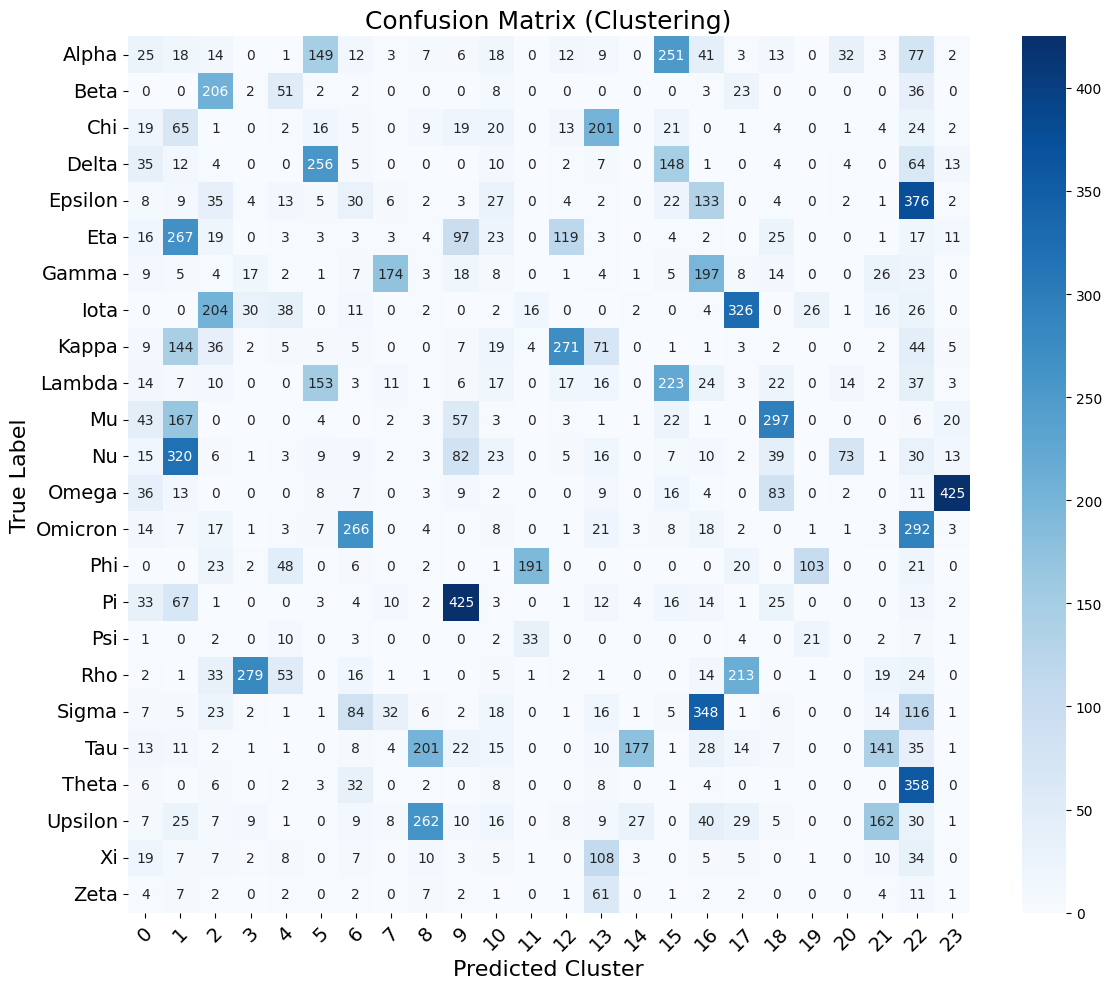

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get label names and unique cluster IDs
true_label_names = le.classes_
cluster_labels_unique = np.unique(cluster_labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=cluster_labels_unique,
    yticklabels=true_label_names
)
ax.set_xlabel('Predicted Cluster', fontsize=16)
ax.set_ylabel('True Label', fontsize=16)
ax.set_title('Confusion Matrix (Clustering)', fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45)

plt.tight_layout()
plt.savefig('clustering_confusion_matrix.pdf', dpi=300, format='PDF')
plt.show()


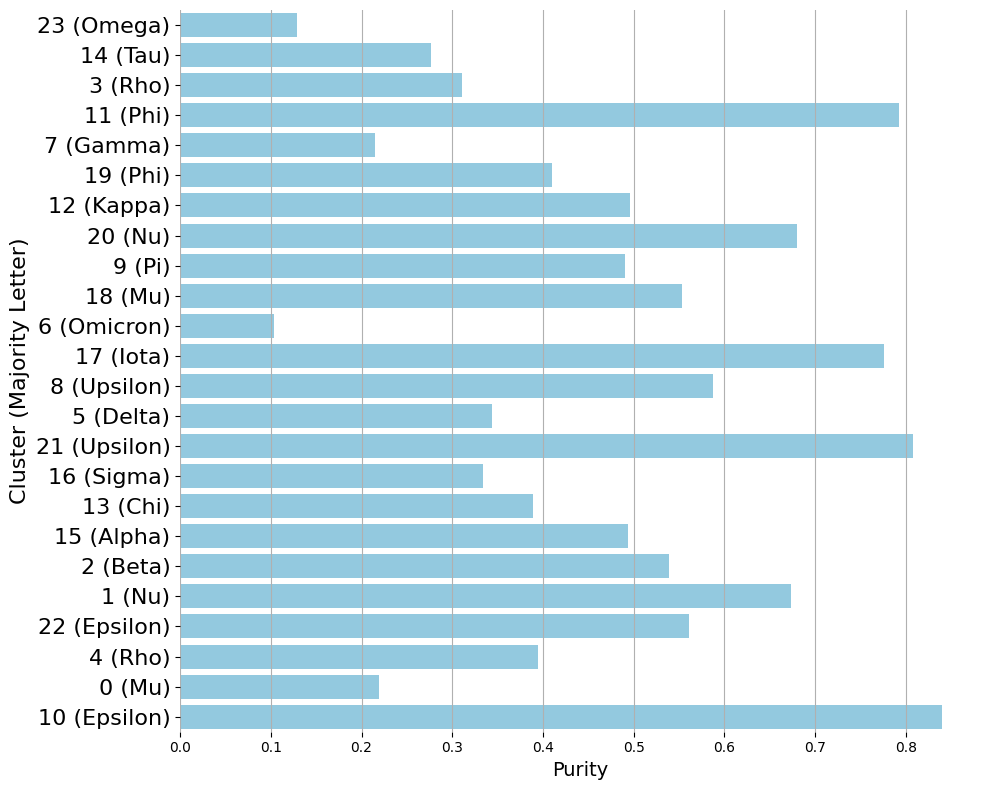

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Confusion matrix: rows = true labels, columns = predicted clusters
cm = confusion_matrix(y_true, y_pred)

# For each cluster, find which true label is most common in that cluster
cluster_purities = []
for cluster_id in np.unique(y_pred):
    # Get indices in this cluster
    indices = np.where(y_pred == cluster_id)[0]
    if len(indices) == 0:
        continue
    # Get true labels in this cluster
    true_labels_in_cluster = y_true[indices]
    # Find the majority class and its count
    unique, counts = np.unique(true_labels_in_cluster, return_counts=True)
    majority_label_index = np.argmax(counts)
    majority_label = unique[majority_label_index]
    majority_letter = le.inverse_transform([majority_label])[0]
    purity = counts[majority_label_index] / len(indices)
    
    cluster_purities.append({
        'Cluster': cluster_id,
        'Purity': purity,
        'Letter': majority_letter,
        'Count': len(indices)
    })

# Convert to DataFrame and sort
purity_df = pd.DataFrame(cluster_purities)
purity_df = purity_df.sort_values(by='Purity', ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Purity', y='Cluster', data=purity_df, orient='h', color='skyblue')
plt.yticks(
    ticks=purity_df.index,
    labels=[f'{c} ({l})' for c, l in zip(purity_df['Cluster'], purity_df['Letter'])],
    fontsize=16
)
plt.xlabel('Purity', fontsize=14)
plt.ylabel('Cluster (Majority Letter)', fontsize=16)
plt.grid(axis='x')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('cluster_purity.pdf', dpi=300, format='PDF')
plt.show()


In [ ]:
# 2. PCA Feature Extraction
from sklearn.cluster import KMeans

def extract_pca_features(X, n_components=50):
    print(f"Applying PCA to reduce to {n_components} dimensions...")
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X)

# 3. Clustering and Visualization
def cluster_and_visualize(X_pca, y):
    print("Performing K-Means Clustering on PCA features...")
    kmeans = KMeans(n_clusters=24, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca)

    nmi = normalized_mutual_info_score(y, cluster_labels)
    print(f"NMI Score: {nmi:.4f}")
    
    return cluster_labels

# Run Full Pipeline
if __name__ == "__main__":
    X, y = known_data, known_labels
    print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")
    X_pca = extract_pca_features(X, n_components=200)
    cluster_labels = cluster_and_visualize(X_pca, y)

Loaded 13014 images with shape (1024,)
Applying PCA to reduce to 200 dimensions...
Performing K-Means Clustering on PCA features...
NMI Score: 0.3512


In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

ground_truth_labels = data['letter'].values
nmi = normalized_mutual_info_score(known_labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi}")
ari = adjusted_rand_score(known_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
# Compute the average silhouette score
average_silhouette = silhouette_score(X_pca, cluster_labels)
print(f"Average Silhouette Score (Micro): {average_silhouette}")

In [ ]:
cluster_silhouette_scores = []
for i in range(24):
    cluster_indices = np.where(cluster_labels == i)[0]
    if len(cluster_indices) > 1: # Silhouette score is only defined for clusters with more than one point
        cluster_silhouette_scores.append(np.mean(sample_silhouette_values[cluster_indices]).item())
macro_silhouette = np.mean(cluster_silhouette_scores) if cluster_silhouette_scores else 0
print(f"Macro Silhouette Score (Average of Cluster Averages): {macro_silhouette}")
dict(zip(range(24), cluster_silhouette_scores))

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def per_class_purity(y_true, y_pred, label_names=None):
    # Encode labels to integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred = np.asarray(y_pred)

    # Build confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred)
    # Map back to class names
    classes = le.classes_ if label_names is None else label_names

    # Compute purity per true class
    purities = {}
    for i, class_name in enumerate(classes):
        total = np.sum(cm[i, :])
        correct = np.max(cm[i, :])  # cluster with max matches for this class
        purities[class_name] = correct / total if total > 0 else 0.0

    return purities
# Convert string labels to numeric and get cluster labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute per-letter purity
per_letter_purity = per_class_purity(known_labels, cluster_labels)

# Sort by purity descending
sorted_purities = sorted(per_letter_purity.items(), key=lambda x: x[1], reverse=True)

# Print nicely
print("Per-letter Purity Scores (sorted):")
for letter, purity in sorted_purities:
    print(f"Letter '{letter}': {purity:.3f}")

# PCA-Net + Spectral Clustering

In [30]:
from skimage.util import view_as_windows

def extract_patches(images, patch_size):
    all_patches = []
    for img in images:
        # Use view_as_windows to extract all patches of size patch_size x patch_size
        patches = view_as_windows(img, (patch_size, patch_size))
        patches = patches.reshape(-1, patch_size * patch_size)
        all_patches.append(patches)
    return np.vstack(all_patches)

def learn_pca_filters(patches, num_filters):
    pca = PCA(n_components=num_filters)
    pca.fit(patches)
    return pca.components_

def apply_filters(images, filters, patch_size):
    # Convolve each image with each filter
    filtered_maps = []
    for img in images:
        fmap = []
        for f in filters:
            kernel = f.reshape(patch_size, patch_size)
            conv = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REFLECT)
            fmap.append(conv)
        filtered_maps.append(np.array(fmap))
    return filtered_maps  # List of arrays shape: (num_filters, H, W)

def binary_hashing(feature_maps):
    # feature_maps shape: (num_filters, H, W)
    binary_maps = (feature_maps > 0).astype(np.uint8)
    hashed = np.zeros_like(binary_maps[0], dtype=np.uint8)
    for i, bmap in enumerate(binary_maps):
        hashed += (bmap << i)
    return hashed

def block_histogram(hashed_image, block_size, num_bins=256):
    H, W = hashed_image.shape
    hist = []
    for y in range(0, H, block_size):
        for x in range(0, W, block_size):
            block = hashed_image[y:y+block_size, x:x+block_size]
            h, _ = np.histogram(block, bins=num_bins, range=(0, num_bins))
            hist.append(h)
    return np.concatenate(hist)

def pcanet_onestage(images, patch_size=7, num_filters=8, block_size=7):
    # Stage 1: learn filters and apply
    patches = extract_patches(images, patch_size)
    filters = learn_pca_filters(patches, num_filters)
    stage_maps = apply_filters(images, filters, patch_size)

    # Hash + Histogram (on stage 1 outputs)
    features = []
    for fmap in stage_maps:
        hashed = binary_hashing(fmap)
        hist = block_histogram(hashed, block_size)
        features.append(hist)

    return np.array(features)

import numpy as np
from collections import defaultdict


images = [img.reshape(32, 32) for img in known_data]

# Extract PCANet features
features = pcanet_onestage(images,
                         patch_size=11,
                         num_filters=16,
                         block_size=7)

print("PCANet features shape:", features.shape)  # (N, feature_vector_length)

PCANet features shape: (13014, 6400)


Running Spectral Clustering...
Spectral Clustering NMI Score: 0.4122


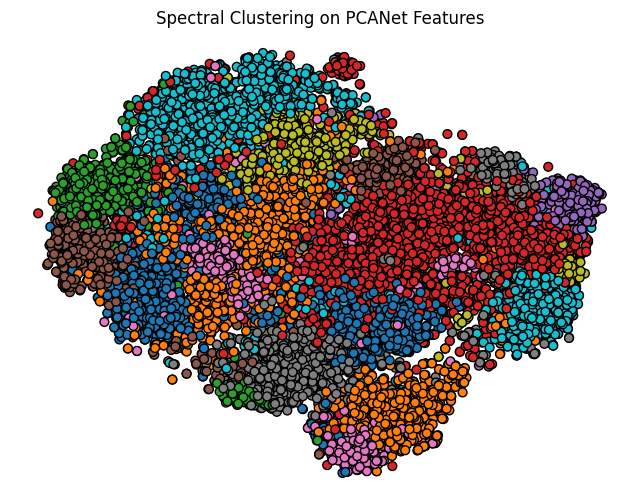

In [31]:
from scipy.signal import convolve2d
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score
from sklearn.manifold import TSNE
from skimage.util import view_as_windows
from scipy.signal import convolve2d
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings("ignore")


# 7. Clustering and Evaluation
def cluster_and_visualize(features, labels):
    # Normalize features (important for spectral clustering)
    features_norm = normalize(features)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=24, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(features_norm)

    # Evaluate clustering quality
    nmi = normalized_mutual_info_score(labels, cluster_labels)
    print(f"Spectral Clustering NMI Score: {nmi:.4f}")

    # Visualize with t-SNE
    vis = TSNE(n_components=2, random_state=42).fit_transform(features_norm)
    plt.figure(figsize=(8, 6))
    plt.scatter(vis[:, 0], vis[:, 1], c=cluster_labels, cmap='tab10', s=40, edgecolor='k')
    plt.title("Spectral Clustering on PCANet Features")
    plt.axis('off')
    plt.show()
    return cluster_labels

print("Running Spectral Clustering...")
cluster_labels = cluster_and_visualize(features, known_labels)

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def per_class_purity(y_true, y_pred, label_names=None):
    # Encode labels to integers
    le = LabelEncoder()
    y_true_encoded = le.fit_transform(y_true)
    y_pred = np.asarray(y_pred)

    # Build confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred)
    # cm = cm.T
    # Map back to class names
    classes = le.classes_ if label_names is None else label_names

    # Compute purity per true class
    purities = {}
    for i, class_name in enumerate(classes):
        total = np.sum(cm[i, :])
        correct = np.max(cm[i, :])  # cluster with max matches for this class
        purities[class_name] = correct / total if total > 0 else 0.0

    return purities
# Convert string labels to numeric and get cluster labels
le = LabelEncoder()
y_true = le.fit_transform(known_labels)
y_pred = cluster_labels.astype(int)

# Compute per-letter purity
per_letter_purity = per_class_purity(known_labels, cluster_labels)

# Sort by purity descending
sorted_purities = sorted(per_letter_purity.items(), key=lambda x: x[1], reverse=True)

# Print nicely
print("Per-letter Purity Scores (sorted):")
for letter, purity in sorted_purities:
    print(f"Letter '{letter}': {purity:.3f}")

Per-letter Purity Scores (sorted):
Letter 'Theta': 0.738
Letter 'Omega': 0.697
Letter 'Pi': 0.671
Letter 'Phi': 0.669
Letter 'Psi': 0.663
Letter 'Beta': 0.640
Letter 'Delta': 0.618
Letter 'Rho': 0.599
Letter 'Epsilon': 0.597
Letter 'Chi': 0.593
Letter 'Iota': 0.557
Letter 'Upsilon': 0.544
Letter 'Gamma': 0.495
Letter 'Xi': 0.489
Letter 'Zeta': 0.473
Letter 'Mu': 0.462
Letter 'Nu': 0.460
Letter 'Omicron': 0.440
Letter 'Sigma': 0.410
Letter 'Lambda': 0.408
Letter 'Kappa': 0.373
Letter 'Alpha': 0.371
Letter 'Tau': 0.337
Letter 'Eta': 0.321


In [33]:
from sklearn.metrics import silhouette_score, silhouette_samples
# Compute silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
# Compute the average silhouette score
average_silhouette = silhouette_score(X_pca, cluster_labels)
print(f"Average Silhouette Score (Micro): {average_silhouette}")

Average Silhouette Score (Micro): -0.007719582412391901
